<a href="https://colab.research.google.com/github/bsaha205/Fall_22_PML/blob/main/PML_HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1



## Part 1

**Framework:** Pytorch

**Dataset:** FashionMNIST from torchvision.datasets (https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).

**Resources:**
1. Optimizer: I used Adam optimizer from torch.optim (https://pytorch.org/docs/stable/optim.html).
2. CNN: Used torch.nn for implementing 2-layer CNN model (https://pytorch.org/docs/stable/nn.html).
3. Plot: For plotting the data, I used matplotlib.pyplot library (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html).
4. Loss function: For loss function, I used cross_entropy loss from F.cross_entropy (https://pytorch.org/docs/stable/nn.functional.html).
5. Class Identify: To identify right class, I used log_softmax from F.log_softmax (https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html).

### Exploratory Data Analysis

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import joblib
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torchvision.models as models

In [70]:
# read FashionMNIST data from torchvision.datasets
train_data = datasets.FashionMNIST('.', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.FashionMNIST('.', train=False, transform=transforms.Compose([transforms.ToTensor()]))

# print the shape of the dataset
print("train images:", train_data.data.size())
print("test images:", test_data.data.size())

train images: torch.Size([60000, 28, 28])
test images: torch.Size([10000, 28, 28])


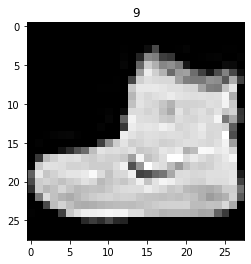

In [71]:
# plot the very first image of train dataset with label
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

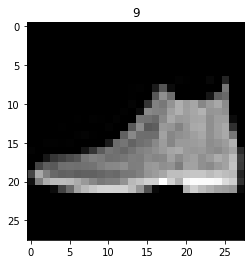

In [72]:
# plot the very first image of test dataset with label
plt.imshow(test_data.data[0].numpy(), cmap='gray')
plt.title('%i' % test_data.targets[0])
plt.show()

### CNN Model

In [73]:
class CNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, k_size, k_size_max_pooling, dropout_prob):
        '''in_dim: input layer dim
           hidden_dim: hidden layer dim
           out_dim: output layer dim'''
        
        super(CNN, self).__init__() 
             
        self.cnn = nn.Conv1d(in_dim, in_dim, k_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.maxpool = nn.MaxPool1d(k_size_max_pooling)
        
        # images are 28x28 so flatten them into 784d vec
        self.flatten = nn.Flatten()
        
        #two fully connected layers
        self.fc1 = nn.Linear(140, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # print(x.shape)
        x = self.cnn(x)
        # print(x.shape)
        
        x = F.relu(x)
        # print(x.shape)
        
        x = self.dropout(x)
        # print(x.shape)
        
        x = self.maxpool(x)
        # print(x.shape)
        
        # since x is 28x28, flatten it first
        x = self.flatten(x)
        # print(x.shape)
        
        # compute output of fc1, and apply relu activation
        x = F.relu(self.fc1(x))
        # print(x.shape)

        # compute output layer, no activation: cross entropy will compute softmax
        x = self.fc2(x)
        return x

### Training

In [74]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

#hyper-paramets defining
batch_size = 1000
learning_rate = 0.01
epochs = 10
in_dim = 28 # images are 28x28 as inputs
hidden_dim = 512 # 512d hidden layer
number_of_class = 10 # output is 10d since there are 10 classes
k_size = 9 # kernel size of CNN
k_size_max_pooling = 4 # kernel size of max pooling
dropout_prob = 0.2 # drop out probability

# set model
model = CNN(in_dim, hidden_dim, number_of_class, k_size, k_size_max_pooling, dropout_prob)

# optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# load training data in batches
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
# send model over to device
model = model.to(device)
model.train()

using device: cpu


CNN(
  (cnn): Conv1d(28, 28, kernel_size=(9,), stride=(1,))
  (dropout): Dropout(p=0.2, inplace=False)
  (maxpool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=140, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Training loop over batches

In [75]:
for epoch in range(1, epochs + 1):    
    sum_valid_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):

        data = torch.squeeze(data) / 255
        # send batch over to device
        data, target = data.to(device), target.to(device)
        
        # zero out prev gradients
        optimizer.zero_grad()
        
        # run the forward pass
        output = model(data)
        
        # compute loss/error
        loss = F.cross_entropy(output, target)

        # I used first 50000 datapoints of train_data as trainig dataset and last 10000 points as validation dataset
        if batch_idx >= 50:
          # sum up batch losses for validation dataset
          sum_valid_loss += loss.item()
          continue
        
        # compute gradients and take a step in training phase
        loss.backward()
        optimizer.step()
        
    # average loss per example    
    sum_valid_loss /= 10000
    print(f'Epoch: {epoch}, Validation Loss: {sum_valid_loss:.6f}')

Epoch: 1, Validation Loss: 0.000961
Epoch: 2, Validation Loss: 0.000759
Epoch: 3, Validation Loss: 0.000680
Epoch: 4, Validation Loss: 0.000608
Epoch: 5, Validation Loss: 0.000579
Epoch: 6, Validation Loss: 0.000564
Epoch: 7, Validation Loss: 0.000556
Epoch: 8, Validation Loss: 0.000541
Epoch: 9, Validation Loss: 0.000498
Epoch: 10, Validation Loss: 0.000482


### Testing

In [76]:
# load test images in batches
test_loader = du.DataLoader(dataset=test_data,
                            batch_size=batch_size,
                            shuffle=True)

# set model in eval mode as we are no longer training
model.eval()
test_loss = 0
correct = 0

# turning of gradient computation that will speed up testing
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        
        data = torch.squeeze(data) / 255
        # send batches to device
        data, target = data.to(device), target.to(device)
        
        # compute forward pass and loss
        output = model(data)
        loss = F.cross_entropy(output, target)
        
        # sum up batch loss
        test_loss += loss.item()

        # get the class of the max log-probability
        output = F.log_softmax(output, dim=1)
        pred = output.max(dim=1)[1]

        # add up number of correct predictions
        correct += torch.sum(pred == target)
  
    # test loss per example
    test_loss /= len(test_loader.dataset)
    
    # final test accuracy
    test_acc = correct / len(test_loader.dataset)
    print(f'Test loss: {test_loss:.6f}, accuracy: {test_acc:.4f}', f'correct: {correct}')

Test loss: 0.000520, accuracy: 0.8207 correct: 8207


Hyperparameters Used:
1. batch_size - tried values (512, 1000, 1024)
2. learning rate - tried values (0.1, 0.01, 0.001)
3. epochs - tried values (5, 10)
4. hidden_dim - tried values (256, 512)
5. layer - tried values (2, 3, 4)

Some best configs:
1. learning rate (0.01), layer (2), epoch (5) - accuracy (0.8646)
2. learning rate (0.001), layer (2), epoch (10) - accuracy (0.8625)
3. learning rate (0.1), layer (2), epoch (10) - accuracy (0.8109)
4. learning rate (0.01), layer (3), epoch (10) - accuracy (**0.8784**)

I used different configurations of hyperparametes to get the best test accuracy. From the above some different configurations, we can see the test accuracy is the highest for learning rate 0.01 and layer 3.

## Part 2

In [88]:
# transform =   transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
#         transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
#         transforms.ToTensor(),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

# model_ft = models.vgg16(pretrained=True)
# num_ftrs = model_ft.classifier[0].in_features
# model_ft.classifier[0] = nn.Linear(num_ftrs, number_of_class)


import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [89]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
# input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(train_data)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

TypeError: ignored

In [87]:
# optimizer (Adam)
optimizer = optim.Adam(model_ft.parameters(), lr=learning_rate)

# send model over to device
model_ft = model_ft.to(device)
model_ft.train()

for epoch in range(1, epochs + 1):    
    sum_valid_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):

        data = torch.squeeze(data)
        # send batch over to device
        data, target = data.to(device), target.to(device)
        
        # zero out prev gradients
        optimizer.zero_grad()
        
        # run the forward pass
        output = model_ft(data)
        
        # compute loss/error
        loss = F.cross_entropy(output, target)

        # I used first 50000 datapoints of train_data as trainig dataset and last 10000 points as validation dataset
        if batch_idx >= 50:
          # sum up batch losses for validation dataset
          sum_valid_loss += loss.item()
          continue
        
        # compute gradients and take a step in training phase
        loss.backward()
        optimizer.step()
        
    # average loss per example    
    sum_valid_loss /= 10000
    print(f'Epoch: {epoch}, Validation Loss: {sum_valid_loss:.6f}')

RuntimeError: ignored